## Partially reproducing "Hyperdimensional computing as a framework for systematic aggregation of image descriptors"

Peer Neubert and Stefan Schubert published a novel application of High Dimensional Computing (HDC) to the domain of Image Description. In their paper "Hyperdimensional computing as a framework for systematic aggregation of image descriptors", they apply the HDC-framework, which works by defining an approximate algebraic field with useful operations for descriptor aggregation, to a Mobile Robot Localization Task.

In [3]:
import os
root = 'descriptors/OxfordRobotCar/'
dates = os.listdir(root)
matfiles = [os.path.join(root, date, 'delf.mat') for date in dates]
matfiles

['descriptors/OxfordRobotCar/2015-05-19-14-06-38/delf.mat',
 'descriptors/OxfordRobotCar/2014-12-09-13-21-02/delf.mat',
 'descriptors/OxfordRobotCar/2014-11-25-09-18-32/delf.mat',
 'descriptors/OxfordRobotCar/2015-08-28-09-50-22/delf.mat']

In [4]:
import scipy.io

data = {mf : scipy.io.loadmat(mf) for mf in matfiles}

In [5]:
from typing import Any
import numpy as np
def __pprint(d : dict | Any) -> str:
    if not isinstance(d, dict):
        if isinstance(d, np.ndarray):
            return f'Array {d.shape}'
        else:
            return str(d)
    else:
        kvs = {str(k) : __pprint(v) for k, v in d.items()}
        return "Dict: \n" + "\n".join("\t" + k + ":" + v for k, v in kvs.items())
def pprint(d : dict):
    print(__pprint(d))

In [6]:
pprint(data['descriptors/OxfordRobotCar/2014-11-25-09-18-32/delf.mat'])

Dict: 
	__header__:b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Nov  5 05:16:59 2020'
	__version__:1.0
	__globals__:[]
	Y:Array (1, 2253)


In [7]:
from typing import *
def order(matlab_objects : dict[str, np.ndarray]) -> dict[str, Tuple[np.ndarray, ...]]:
    """
        Returns numpy arrays for each matlab file for easier handling.
    """
    ret = {}
    for sourcefile, matlab_object in matlab_objects.items():
        data = matlab_object['Y'].squeeze()
        # small research on DELF - DELF returns keypoints (x, y) (or (y, x) ?), scores (s) which
        # are presumably attention scores and descriptors.
        keypoints, scores, descriptors = \
            np.stack(arrays=data['keypoints'], dtype=np.float32), \
            np.stack(arrays=data['scores'], dtype=np.float32), \
            np.stack(arrays=data['descriptors'], dtype=np.float32)
        ret[sourcefile] = (keypoints, scores, descriptors)
    return ret

In [8]:
npdata = order(data)

In [9]:
del data

In [10]:
_ = [print(key, [x.shape for x in npdata[key]]) for key in npdata]

descriptors/OxfordRobotCar/2015-05-19-14-06-38/delf.mat [(1967, 200, 2), (1967, 200, 1), (1967, 200, 1024)]
descriptors/OxfordRobotCar/2014-12-09-13-21-02/delf.mat [(2133, 200, 2), (2133, 200, 1), (2133, 200, 1024)]
descriptors/OxfordRobotCar/2014-11-25-09-18-32/delf.mat [(2253, 200, 2), (2253, 200, 1), (2253, 200, 1024)]
descriptors/OxfordRobotCar/2015-08-28-09-50-22/delf.mat [(1991, 200, 2), (1991, 200, 1), (1991, 200, 1024)]


In [11]:
# lets take a look at ground truth files to see what we're trying to map to
gtroot = "ground_truth/OxfordRobotCar/"
gtfiles = [os.path.join(gtroot, filename, 'gt.mat') for filename in os.listdir(gtroot)]

In [12]:
gtfiles

['ground_truth/OxfordRobotCar/2014-12-09-13-21-02--2015-08-28-09-50-22/gt.mat',
 'ground_truth/OxfordRobotCar/2014-12-09-13-21-02--2015-05-19-14-06-38/gt.mat']

In [13]:
import h5py
def _read_h5_dataset(obj):
    """Convert an h5py object (dataset or group) into a Python object."""
    
    # Case 1: HDF5 Dataset → NumPy array
    if isinstance(obj, h5py.Dataset):
        data = obj[()]  # read entire dataset
        
        # Decode byte strings
        if isinstance(data, bytes):
            return data.decode("utf-8")
        if isinstance(data, np.ndarray) and data.dtype.kind == 'S':
            return data.astype(str)
        
        return data

    # Case 2: HDF5 Group → dict (MATLAB struct)
    elif isinstance(obj, h5py.Group):
        result = {}
        for key in obj.keys():
            result[key] = _read_h5_dataset(obj[key])
        return result

    # Fallback
    return obj


def load_mat_v7_3(filepath):
    """Load MATLAB v7.3 .mat file into a nested Python dictionary."""
    result = {}
    with h5py.File(filepath, "r") as f:
        for key in f.keys():
            result[key] = _read_h5_dataset(f[key])
    return result

In [14]:
gtdata = [
    load_mat_v7_3(file) for file in gtfiles
]

In [19]:
gtfiles

['ground_truth/OxfordRobotCar/2014-12-09-13-21-02--2015-08-28-09-50-22/gt.mat',
 'ground_truth/OxfordRobotCar/2014-12-09-13-21-02--2015-05-19-14-06-38/gt.mat']

In [15]:
gtdata[0]['GT'].keys()

dict_keys(['GThard', 'GThard_cmd', 'GTsoft', 'GTsoft_cmd', 'Info', 'version'])

In [16]:
gtdata[0]['GT']['GThard'].shape

(1991, 2133)

In [17]:
gtdata[1]['GT']['GThard'].shape

(1967, 2133)

In [18]:
gtdata[0]['GT']['GThard'].sum(), gtdata[0]['GT']['GTsoft'].sum()

(np.uint64(2983), np.uint64(34809))

In [20]:
gtdata = {f : v for f, v in zip(gtfiles, gtdata)}

### Notes
seems like the ground truth is a matrix n x m where n is the 
number of training samples in 2014-12-09 and m is the number of test
samples in 2015-05-19. When training sample i matches test sample j, we
get 1 else 0. - check whether this is correct intuition.
hard ground truth is (almost) exact image matches and soft ground truth
is ~about same location image match?

- candidates reproduce HDC-DELF rows:
- DB: 2014-12-09 Query: 2015-05-19 -- 0.91
- DB: 2015-05-19 Query: 2014-12-09 -- not given in table
- DB: 2014-12-09 Query: 2015-08-28 -- 0.71
- DB: 2015-08-28 Query: 2014-12-09 -- not given in table

thought: WOuld the test-metrics for swapping DB and Query set be identical? This would explain
why there are only 6 rows in the table (3 + 2 + 1 comparisons between 4 datasets)
- Counter example: very unbalanced train/test datasets - The performance wouldn't be symmetric.
- Also I've noticed that there is "2014-12-16-18-44-24" dataset which isn't present in the data.
- I can only reproduce 2014-12-09 Query: 2015-05-19 -- 0.91, 2014-12-09 Query: 2015-08-28 -- 0.71

### Requirements:

- get image width/height to do the positional encodings 
    - just search for the dataset and validate with positions from data
    - Visited: https://robotcar-dataset.robots.ox.ac.uk/datasets/
    - Looking for Specific dates of our datasets:
        - 2014-12-09:
            - multiple image resolutions: 
            1280x960, 1024x1024
        - 2015-05-19:
            - multiple image resolutions: 
            1280x960, 1024x1024
    - take another look at paper to see whether i can find info.
    - It's likely the front camera with resolution 1280x960, that's at least the image i could find in the paper.
    - check:
        - compute max over keypoints over all training data.
        - For 2014-12-09 this gives (np.float32(928.0), np.float32(1248.0))
        - => Keypoints are in range (960, 1280) (height, width)

- implement the positional encoding scheme.
    - take another look at the paper. I think they just use random vectors.
- implement the gaussian random projection to project DELF vectors into higher dimension.
- think about evaluation protocol. 
    - We're always setting one dataset as database set, another as query set.
    - We're computing matching scores for each database sample and choose the one with highest score as prediction
    - THen, we're looking up the ground truth table to see whether position (i, j) == 1
    - We get accuracy scores for hard ground truth and soft ground truth.

In [21]:
d = npdata['descriptors/OxfordRobotCar/2014-12-09-13-21-02/delf.mat'][0]
np.amax(d[..., 0], axis=(0, 1)), np.amax(d[..., 1], axis=(0, 1))

(np.float32(928.0), np.float32(1248.0))

In [24]:
### My current memory is completely filled. Let's save these datasets to file and delete them from memory.
import pickle
with open('DB_2014-12__Q_2015-05.pickle', 'wb') as file:
    pickle.dump({
        'db' : npdata['descriptors/OxfordRobotCar/2014-12-09-13-21-02/delf.mat'],
        'query' : npdata['descriptors/OxfordRobotCar/2015-05-19-14-06-38/delf.mat'],
        'gt' : {
            'hard' : gtdata['ground_truth/OxfordRobotCar/2014-12-09-13-21-02--2015-05-19-14-06-38/gt.mat']['GT']['GThard'],
            'soft' : gtdata['ground_truth/OxfordRobotCar/2014-12-09-13-21-02--2015-05-19-14-06-38/gt.mat']['GT']['GTsoft']
        }
    }, file)

In [25]:
with open('DB_2014-12__Q_2015-08.pickle', 'wb') as file:
    pickle.dump({
        'db' : npdata['descriptors/OxfordRobotCar/2014-12-09-13-21-02/delf.mat'],
        'query' : npdata['descriptors/OxfordRobotCar/2015-08-28-09-50-22/delf.mat'],
        'gt' : {
            'hard' : gtdata['ground_truth/OxfordRobotCar/2014-12-09-13-21-02--2015-08-28-09-50-22/gt.mat']['GT']['GThard'],
            'soft' : gtdata['ground_truth/OxfordRobotCar/2014-12-09-13-21-02--2015-08-28-09-50-22/gt.mat']['GT']['GTsoft']
        }
    }, file)

In [ ]:
del npdata, gtdata

In [1]:
from embed2 import nx, ny, xb, yb, binsizex, binsizey, w, h, d, bxs, bys

In [2]:
print(xb, binsizex) # ==> keypoints will never lie on internal border
print(yb, binsizey) # ==> keypoints may lie on internal border...

[  0. 320. 640. 960.] 320.0
[   0.  256.  512.  768. 1024. 1280.] 256.0


In [3]:
def positional_encoding(x : int, y : int):
    # Bin x, y into bins to get indices
    # This digitize behaviour is weird. I'll cover edgecases.
    xi, yi = np.digitize(x, xb) - 1, np.digitize(y, yb) - 1
    xi, yi = min(max(0, xi), nx - 1), min(max(0, yi), ny - 1) # in case point lies on edge...
    Bxl, Bxr = bxs[xi], bxs[xi + 1]
    Byl, Byr = bys[yi], bys[yi + 1] # left/right maps to up/down in world coordinates and low/high in image coordinates.
    
    delta_x_l = x % int(binsizex) # approximate
    delta_x_r = binsizex - delta_x_l
    delta_y_l = y % int(binsizey) # exact
    delta_y_r = binsizey - delta_y_l

    # print('delta_x_l: ', delta_x_l, ' delta_x_r: ', delta_x_r)
    # print('delta_y_l: ', delta_y_l, ' delta_y_r: ', delta_y_r)
    
    alpha_x = int(np.round(d * delta_x_r / binsizex))
    alpha_y = int(np.round(d * delta_y_r / binsizey))

    # print('alphax: ', alpha_x, ' alphay: ', alpha_y)
    X = np.concat([Bxl[:alpha_x], Bxr[alpha_x:]])
    Y = np.concat([Byl[:alpha_y], Byr[alpha_y:]])
    P = X * Y
    return P

In [4]:
# sanity check: lets repeat the heatmap plot from the paper:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
anchor = (500, 900)
xi, yi = np.meshgrid(np.linspace(0, w, 100), np.linspace(0, h, 100))
anchor_embedding = positional_encoding(*anchor)
other_embeddings = np.stack([positional_encoding(x, y) for x, y in zip(xi.flatten(), yi.flatten())])
similarities = np.array([cosine(anchor_embedding, other) for other in other_embeddings])

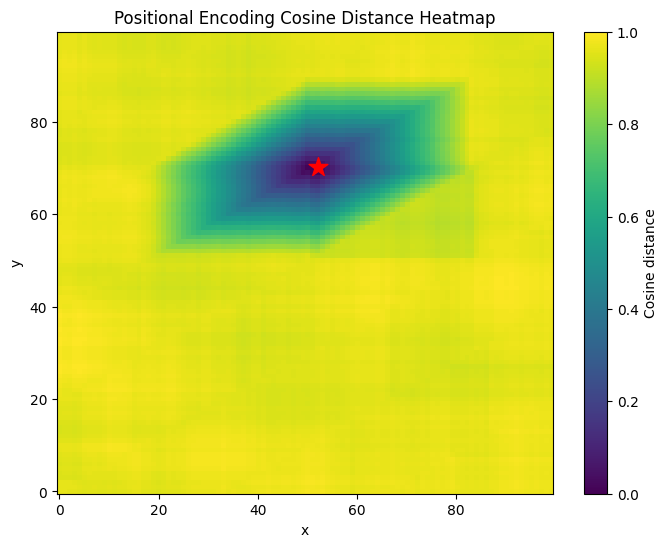

In [5]:
sim_grid = similarities.reshape(100, 100)

plt.figure(figsize=(8, 6))
plt.imshow(sim_grid, origin='lower', aspect='auto')
plt.scatter(anchor[0] / w * 100, anchor[1] / h * 100, color='red', marker='*', s=200)
plt.colorbar(label="Cosine distance")
plt.title("Positional Encoding Cosine Distance Heatmap")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Notes:

- seems to be working alright enough to continue.
- nextup: gaussian random projection.
    -> read up on wiki/chatgpt
    -> sklearn library for random projections.

In [ ]:
from sklearn.random_projection import GaussianRandomProjection

mock_data = np.random.choice([-1, 1], size=(100, 1024))
grp = GaussianRandomProjection(n_components=d)
xs = grp.fit_transform(mock_data)

In [ ]:
# check whether the vectors are still almost orthogonal:
# make histogram over the cosines between vectors:

distances = np.stack([np.stack([cosine(x, y) for j, x in enumerate(xs) if i != j]) for i, y in enumerate(xs)]).flatten()

In [ ]:
plt.hist(distances, bins=30)
plt.show()

Distances are still far from each other. Seems okay.

In [ ]:
del grp, mock_data, xs, distances

### Evaluation

Now i have everything to conduct the experiment. Plan:
- load in the datasets (database, query, ground truths)
- define an embedding function for feature descriptor
    -> fit_transform with the GaussianRandomProjection object from sklearn
    -> Returns feat := [num_samples, batch, data] tensor
- re-use embedding function for position
    -> Returns pos := [num_samples, batch, data] tensor
- define function for entangling and storing data
    -> Should just feat * pos, then sum over batch dimension. We're left with [num_samples, data] tensor
- Do the same for the query set.
- Define a function which returns the index of the best match in database.
    -> whats the evaluation protocol in the paper like? Anyways, i cannot majority vote because i have no labels for data.
    -> could instead do recall analysis.
    -> save for later.
     

### Note
Due to OOM I'm computing the encodings of the database and query in a python script and load in the data here.

In [1]:
import pickle
import numpy as np

from evaluate import evaluate

In [2]:
with open('preprocessed-DB_2014-12__Q_2015-05.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()
gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))
with open('preprocessed-DB_2014-12__Q_2015-08.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()

gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))

0.001525165226232842 0.04931367564819522


IndexError: index 1967 is out of bounds for axis 1 with size 1967

#### Notes

- I'm assuming the reported accuracy was on the soft ground truth for now.
- There is still a discrepancy between the accuracies.
    - I'm currently sampling from {-1, 1} not [-1, 1]
    - I'm not normalizing per image yet.
- Lets repeat the evaluations, but lets implement the two changes.

### Normalized over feature dimension (per-image), sampling from [-1, 1]

- calculating the mean, std per image, then normalizing
- applied before gaussian random projection

In [ ]:
with open('exp2-preprocessed-DB_2014-12__Q_2015-05.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()
gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))

with open('exp2-preprocessed-DB_2014-12__Q_2015-08.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()

gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))

### Normalized over num_samples + feature dimension

- collecting the mean, std from the database set. We're calculating the mean over the first two dimensions (num_samples, features)
- applying before gaussian random projection

In [ ]:
with open('exp3-preprocessed-DB_2014-12__Q_2015-05.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()
gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))

with open('exp3-preprocessed-DB_2014-12__Q_2015-08.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()

gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))

### Normalize over feature dimension after Gaussian Random Projection


In [ ]:
with open('exp4-preprocessed-DB_2014-12__Q_2015-05.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()
gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))

with open('exp4-preprocessed-DB_2014-12__Q_2015-08.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()

gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))

### Further Ideas

- why not try to use unbinding in the classification process.
    - Currently $L_i = \sum_j^M P_j \odot F_j$. We aren't using the score for each feature here.
    - We could instead $L_i = \sum_j^M P_j \odot F_j \odot I_j$ where $I_j$ is a random vector with role "j-th highest score"
    - For classification, we could then instead of taking the best match take the top-m matches and unbind the top-f features for comparison
 

### Base classification performance with additional Index binding

In [ ]:
with open('exp5-preprocessed-DB_2014-12__Q_2015-05.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()
gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))

with open('exp5-preprocessed-DB_2014-12__Q_2015-08.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()

gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate(db, query, gt_hard), evaluate(db, query, gt_soft))

### Classification performance with unbind-aware evaluation

- we're adding two hyperparameters to the evaluation:
    - `topm` the number of best-matches to evaluate against a query sample.
    - `topf` the number of top-features to unbind from the bundled vector.

In [ ]:
import pickle
from evaluate import evaluate_with_unbind

In [ ]:
topm, topf = 15, 3
with open('exp5-preprocessed-DB_2014-12__Q_2015-05.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()
gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate_with_unbind(db, query, gt_hard, topm=topm, topf=topf), evaluate_with_unbind(db, query, gt_soft, topm=topm, topf=topf))

with open('exp5-preprocessed-DB_2014-12__Q_2015-08.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()

gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate_with_unbind(db, query, gt_hard, topm=topm, topf=topf), evaluate_with_unbind(db, query, gt_soft, topm=topm, topf=topf))

In [ ]:
topm, topf = 3, 15
with open('exp5-preprocessed-DB_2014-12__Q_2015-05.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()
gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate_with_unbind(db, query, gt_hard, topm=topm, topf=topf), evaluate_with_unbind(db, query, gt_soft, topm=topm, topf=topf))

with open('exp5-preprocessed-DB_2014-12__Q_2015-08.pickle', 'rb') as file:
    tmp = pickle.load(file)
    db, query, gts = tmp.values()

gt_hard, gt_soft = gts['hard'].T, gts['soft'].T
print(evaluate_with_unbind(db, query, gt_hard, topm=topm, topf=topf), evaluate_with_unbind(db, query, gt_soft, topm=topm, topf=topf))

### Notes

Underwhelming results, perhaps the loss of information by binding and unbinding again is too large? An upper bound for this method would anyways be DELF results with
~0.94 and ~0.34 (?) respectively.